In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

# paths of folders and imge sizes, batch


In [ ]:
# 1. PATHS – EDIT THESE TO YOUR FOLDERS

train_dir = r"D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\train"
val_dir   = r"D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\val"
test_dir  = r"D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\test"

img_size = (224, 224)
batch_size = 32

print("Train dir:", train_dir)
print("Val dir  :", val_dir)
print("Test dir :", test_dir)

Train dir: D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\train
Val dir  : D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\val
Test dir : D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\test


# LOAD DATASETS

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names
print("Class names (index 0,1):", class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Class names (index 0,1): ['NORMAL', 'PNEUMONIA']


# AUTOTUNING THE MODEL SO THE NEXT BATCH LOAD FASTLY

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# HANDLE IMBALANCE WITH CLASS WEIGHTS

In [ ]:
all_labels = []
for _, label in train_ds.unbatch():   # label is scalar
    all_labels.append(int(label.numpy()))

all_labels = np.array(all_labels)
print("Label counts [NORMAL, PNEUMONIA]:", np.bincount(all_labels))

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),  # 0 -> NORMAL, 1 -> PNEUMONIA
    y=all_labels
)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)

C:\Users\shreeyansh\AppData\Local\Temp\ipykernel_14632\430214857.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_labels.append(int(label.numpy()))


Label counts [NORMAL, PNEUMONIA]: [1341 3875]
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


# BUILD TRANSFER LEARNING CNN (MOBILENETV2 BACKBONE)

In [ ]:
base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze backbone first


# TRAIN TOP LAYERS BY CNN

In [ ]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = preprocess_input(inputs)                 # preprocess for MobileNetV2
x = base_model(x, training=False)           # feature extractor
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # binary classification

model = tf.keras.Model(inputs, outputs)


# COMPILE THE MODEL

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=1e-4,    # start with lower lr than Adam
    rho=0.9
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

# 5. TRAIN MODEL

In [ ]:
epochs = 8

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights    # important for imbalance
)


Epoch 1/8
163/163 [==============================] - 25s 121ms/step - loss: 0.5931 - accuracy: 0.7258 - val_loss: 0.5400 - val_accuracy: 0.7500
Epoch 2/8
163/163 [==============================] - 14s 81ms/step - loss: 0.4026 - accuracy: 0.8455 - val_loss: 0.4135 - val_accuracy: 0.8125
Epoch 3/8
163/163 [==============================] - 8s 47ms/step - loss: 0.3025 - accuracy: 0.8934 - val_loss: 0.3452 - val_accuracy: 0.8125
Epoch 4/8
163/163 [==============================] - 8s 44ms/step - loss: 0.2494 - accuracy: 0.9124 - val_loss: 0.3068 - val_accuracy: 0.8750
Epoch 5/8
163/163 [==============================] - 8s 45ms/step - loss: 0.2138 - accuracy: 0.9241 - val_loss: 0.2830 - val_accuracy: 0.9375
Epoch 6/8
163/163 [==============================] - 8s 45ms/step - loss: 0.1957 - accuracy: 0.9285 - val_loss: 0.2642 - val_accuracy: 0.9375
Epoch 7/8
163/163 [==============================] - 8s 45ms/step - loss: 0.1830 - accuracy: 0.9331 - val_loss: 0.2576 - val_accuracy: 0.9375
Epo

# 6. EVALUATE ON TEST SET

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("\nTest accuracy:", test_acc)

20/20 [==============================] - 1s 45ms/step - loss: 0.2823 - accuracy: 0.8766

Test accuracy: 0.8766025900840759


# 7. PLOT TRAINING CURVES

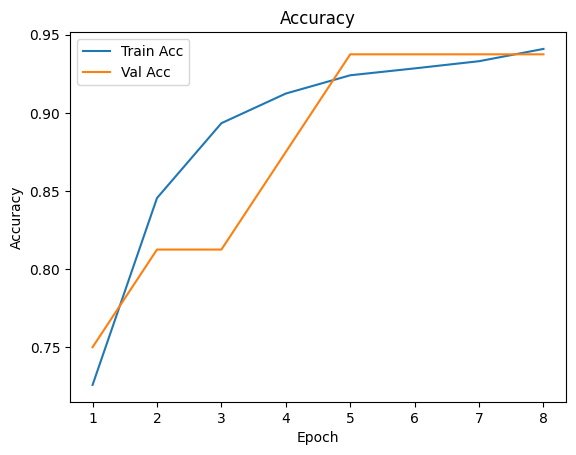

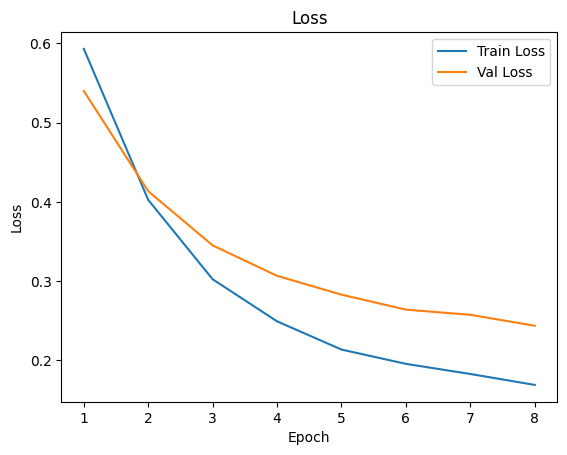

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

# 8. CONFUSION MATRIX ON TEST SET

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images).reshape(-1)  # prob for class index 1 (PNEUMONIA)
    preds = (probs > 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

1/1 [==============================] - 0s 496ms/step

Confusion matrix (rows=true, cols=pred):
[[166  68]
 [  9 381]]

Classification report:
              precision    recall  f1-score   support

      NORMAL     0.9486    0.7094    0.8117       234
   PNEUMONIA     0.8486    0.9769    0.9082       390

    accuracy                         0.8766       624
   macro avg     0.8986    0.8432    0.8600       624
weighted avg     0.8861    0.8766    0.8720       624



# 9. PREPARE IMAGE FOR PREDICTION

In [ ]:
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img



# 10. USER INPUT IMAGE PREDICTION

1/1 [==============================] - 0s 21ms/step

Single image: D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0029-0001.jpeg
Raw probability (PNEUMONIA): 0.9948538
Predicted label: PNEUMONIA


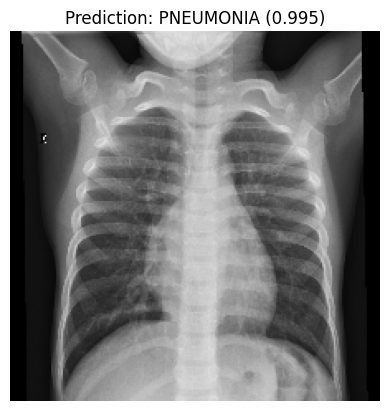

In [ ]:
import os
single_img_path = r"D:\ML,DL,OPENCV ENVN\detect pneumonia PROJECT\chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0029-0001.jpeg"

if os.path.exists(single_img_path):
    img_data, img_vis = prepare_image(single_img_path)
    prob = model.predict(img_data)[0][0]   # probability of class 'PNEUMONIA' (index 1)

    neg_class = class_names[0]  # 'NORMAL'
    pos_class = class_names[1]  # 'PNEUMONIA'

    pred_label = pos_class if prob > 0.5 else neg_class

    print(f"\nSingle image: {single_img_path}")
    print("Raw probability (PNEUMONIA):", prob)
    print("Predicted label:", pred_label)

    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"Prediction: {pred_label} ({prob:.3f})")
    plt.show()
else:
    print(f"\nSingle image path does not exist: {single_img_path}")


# 11. SHOW 10 SAMPLE IMAGES FROM TEST SET WITH PRED + TRUE


10 sample predictions from test set with images:
1/1 [==============================] - 0s 70ms/step
Sample 0: prob=0.140, pred=NORMAL, true=NORMAL


C:\Users\shreeyansh\AppData\Local\Temp\ipykernel_14632\1898732332.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_idx = int(labels[i].numpy())


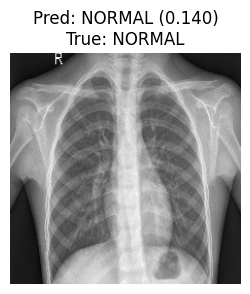

Sample 1: prob=0.070, pred=NORMAL, true=NORMAL


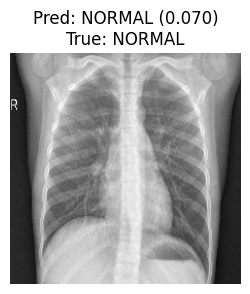

Sample 2: prob=0.105, pred=NORMAL, true=NORMAL


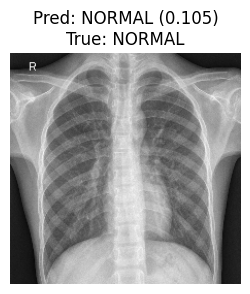

Sample 3: prob=0.453, pred=NORMAL, true=NORMAL


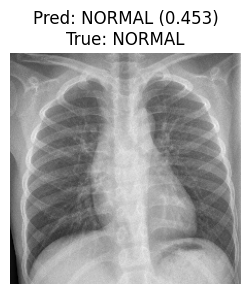

Sample 4: prob=0.151, pred=NORMAL, true=NORMAL


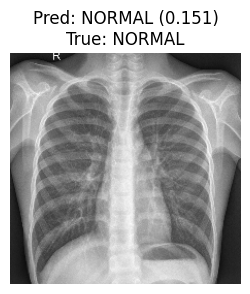

Sample 5: prob=0.053, pred=NORMAL, true=NORMAL


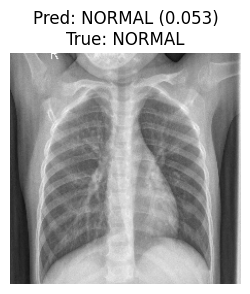

Sample 6: prob=0.074, pred=NORMAL, true=NORMAL


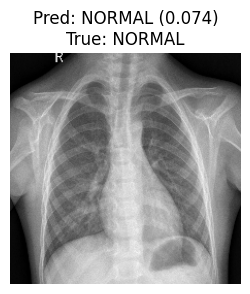

Sample 7: prob=0.223, pred=NORMAL, true=NORMAL


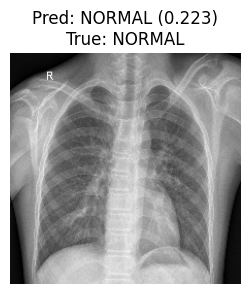

Sample 8: prob=0.328, pred=NORMAL, true=NORMAL


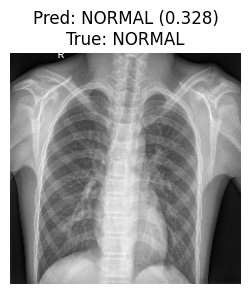

Sample 9: prob=0.023, pred=NORMAL, true=NORMAL


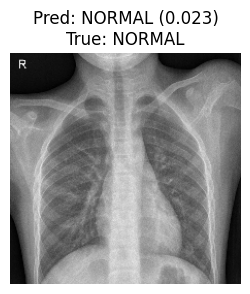

In [ ]:
print("\n10 sample predictions from test set with images:")

import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):  # take 1 batch
    probs = model.predict(images).reshape(-1)
    num_samples = min(10, len(probs))

    for i in range(num_samples):
        prob = probs[i]
        pred_idx = int(prob > 0.5)
        true_idx = int(labels[i].numpy())

        pred_label = class_names[pred_idx]
        true_label = class_names[true_idx]

        print(
            f"Sample {i}: prob={prob:.3f}, "
            f"pred={pred_label}, true={true_label}"
        )

        plt.figure(figsize=(3, 3))
        # images[i] is still in [0,255] range, show directly
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Pred: {pred_label} ({prob:.3f})\nTrue: {true_label}")
        plt.show()